In [18]:
#!pip install transformers
#!pip install spacy
!python -m spacy download de_core_news_lg

2024-01-29 09:18:14.630265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 09:18:14.630323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 09:18:14.634555: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 09:18:15.913403: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.8/567.8 MB 2.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_lg')


In [19]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [20]:
import spacy
nlp = spacy.load('de_core_news_lg', disable=['ner'])

In [1]:
import pandas as pd
from sklearn import metrics as sk_metrics
from collections import Counter

from tqdm import tqdm
tqdm.pandas()

from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
import torch

from ast import literal_eval

from IPython.display import display, Markdown

In [22]:
def print_sentences(occupation, sample=-1, annotated_by=None):
    speech_ids = exploded[exploded.tokens == occupation].speech_id.unique()
    if (sample > 0) & (len(speech_ids) > sample):
        filtered = speeches[speeches.speech_id.isin(speech_ids)].sample(n=sample)
    else:
        filtered = speeches[speeches.speech_id.isin(speech_ids)]
    for i, row in filtered.iterrows():
        for idx, t in enumerate(row.spacydoc):
            if t.text == occupation:
                is_relevant = False

                sent = t.sent
                start = sent.start
                end = sent.end
                bert_anno = row.BERT[start:end]
                matcher_anno = row.matcher[start:end]
                tokens = row.tokens[start:end]
                lemma = [t.lemma_ for t in sent]

                for t_i, t in enumerate(tokens):
                    b_a = bert_anno[t_i]
                    m_a = matcher_anno[t_i]

                    if annotated_by == 'BERT':
                        if (t == occupation) & (b_a == 1):
                            is_relevant = True
                    elif annotated_by == 'matcher':
                        if (t == occupation) & (m_a == 1):
                            is_relevant = True
                    else:
                        is_relevant = True

                    if (b_a == 1) & (m_a == 1):
                        tokens[t_i] = "<font color='green'> {} </font>".format(tokens[t_i])
                        lemma[t_i] = "<font color='green'> {} </font>".format(lemma[t_i])
                    elif (b_a == 1) & (m_a == 0):
                        tokens[t_i] = "<font color='orange'> {} </font>".format(tokens[t_i])
                        lemma[t_i] = "<font color='orange'> {} </font>".format(lemma[t_i])
                    elif (b_a == 0) & (m_a == 1):
                        tokens[t_i] = "<font color='brown'> {} </font>".format(tokens[t_i])
                        lemma[t_i] = "<font color='brown'> {} </font>".format(lemma[t_i])
                    elif (b_a == 0) & (m_a == 0) & (t == occupation):
                        tokens[t_i] = "<font color='red'> {} </font>".format(tokens[t_i])
                        lemma[t_i] = "<font color='red'> {} </font>".format(lemma[t_i])

                if is_relevant == False:
                    continue
                print(i, row.speech_id)
                display(Markdown(' '.join(tokens)))
                print('predicted BERT:\t\t', bert_anno)
                print('predicted Matcher:\t', matcher_anno)

                inputs = tokenizer(' '.join(row.tokens[start:end]), return_tensors="pt")

                with torch.no_grad():
                    logits = model(**inputs).logits

                predictions = torch.argmax(logits, dim=2)
                predicted_token_class = [model.config.id2label[t.item()] for t in predictions[0]]

                probs = logits.numpy()
                res_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].flatten())
                for i, t in enumerate(res_tokens):
                    prob_o = probs[0,i,0]
                    prob_prof = probs[0,i,1]
                    prob_dif = prob_prof - prob_o
                    print('{}\t{}\t{}\t'.format(predicted_token_class[i], prob_dif, t))

                print('###\n\n')

In [23]:
model_checkpoint = 'johannabi/german_tc_professions_debates'
token_classifier = pipeline("token-classification", model=model_checkpoint, aggregation_strategy="max")#, use_auth_token=True)

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

In [24]:
speeches = pd.read_csv('../data/speeches_2010_sample_result.csv', index_col=0)
speeches['tokens'] = speeches['tokens'].apply(lambda x: literal_eval(x))
speeches['matcher'] = speeches['matcher'].apply(lambda x: literal_eval(x))
speeches['BERT'] = speeches['BERT'].apply(lambda x: literal_eval(x))
speeches['spacydoc'] = [doc for doc in tqdm(nlp.pipe(speeches.speech_content))]
speeches.head()

2000it [01:07, 29.67it/s]


,speech_id,speech_content,tokens,speech_content.1,BERT,matcher,spacydoc
0,742625,Sehr geehrter Herr Präsident! Liebe Kolleginne...,"[Sehr, geehrter, Herr, Präsident, !, Liebe, Ko...",Sehr geehrter Herr Präsident! Liebe Kolleginne...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(Sehr, geehrter, Herr, Präsident, !, Liebe, Ko..."
1,744419,Frau Präsidentin! Meine Damen und Herren! Wer ...,"[Frau, Präsidentin, !, Meine, Damen, und, Herr...",Frau Präsidentin! Meine Damen und Herren! Wer ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(Frau, Präsidentin, !, Meine, Damen, und, Herr..."
2,742737,Sehr geehrte Frau Präsidentin! Sehr geehrte Ko...,"[Sehr, geehrte, Frau, Präsidentin, !, Sehr, ge...",Sehr geehrte Frau Präsidentin! Sehr geehrte Ko...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(Sehr, geehrte, Frau, Präsidentin, !, Sehr, ge..."
3,732664,"Herr Kollege Krischer, die letzte Frage hat au...","[Herr, Kollege, Krischer, ,, die, letzte, Frag...","Herr Kollege Krischer, die letzte Frage hat au...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(Herr, Kollege, Krischer, ,, die, letzte, Frag..."
4,740709,Herr Bundestagspräsident! Meine Damen und Herr...,"[Herr, Bundestagspräsident, !, Meine, Damen, u...",Herr Bundestagspräsident! Meine Damen und Herr...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(Herr, Bundestagspräsident, !, Meine, Damen, u..."


In [25]:
exploded = speeches.explode(['matcher', 'BERT', 'tokens'])
sk_metrics.confusion_matrix(list(exploded.matcher), list(exploded.BERT))

array([[978242,   1324],
       [  2100,   1185]])

In [26]:
exploded.BERT.value_counts(dropna=False)

0    980342
1      2509
Name: BERT, dtype: int64

In [27]:
exploded.matcher.value_counts(dropna=False)

0    979566
1      3285
Name: matcher, dtype: int64

In [28]:
bert_annotated = list()
matcher_annotated = list()
all_tokens = list()

for t, b, m in zip(exploded.tokens, exploded.BERT, exploded.matcher):
    all_tokens.append(t)
    if b == 1:
        bert_annotated.append(t)
    if m == 1:
        matcher_annotated.append(t)

bert_counter = Counter(bert_annotated)
matcher_counter = Counter(matcher_annotated)
all_counter = Counter(all_tokens)
all_occupations = set(bert_annotated).union(matcher_annotated)
len(all_occupations)

991

In [29]:


tuples = list()
for occ in all_occupations:
    tuples.append((occ, all_counter[occ], bert_counter[occ], matcher_counter[occ], bert_counter[occ] - matcher_counter[occ]))
comp_df = pd.DataFrame(tuples, columns=['occupation', 'in_corpus', 'bert', 'matcher', 'div'])
comp_df.set_index('occupation', drop=True, inplace=True)

# Daten sortieren und die Top 30 auswählen
most_common_bert = comp_df.sort_values('bert', ascending=True).tail(30)
most_common_matcher = comp_df.sort_values('matcher', ascending=True).tail(30)

# Breite der Balken
bar_width = 0.6  # Passen Sie den Wert nach Bedarf an
figsize=(5, 7)

# RGB-Werte für Grautöne
color_matcher = (0.17, 1.0, 0.22)  # gruen für 'matcher'
color_bert = (0.25, 0.2, 1.0)  # blau für 'bert'
color_in_corpus = (1.0, 0.22, 0.33)  # rot für 'in_corpus'

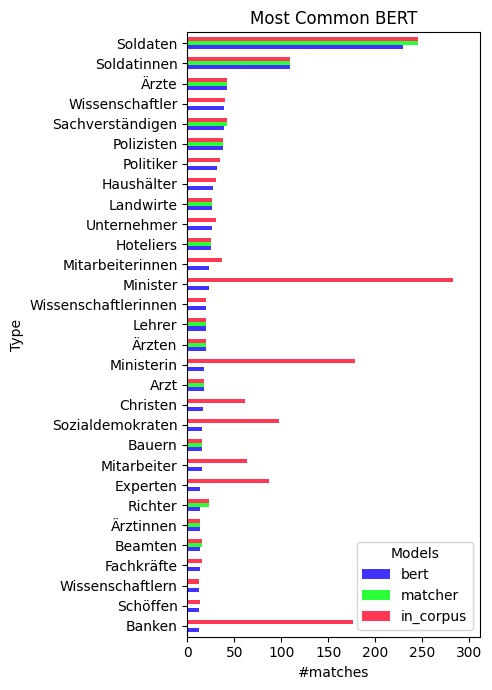

In [30]:
# Plot für Most Common BERT
ax1 = most_common_bert[['bert', 'matcher', 'in_corpus']].plot(kind='barh', width=bar_width, ylabel='Type',
                                                              title='Most Common BERT', color=[color_bert, color_matcher, color_in_corpus],
                                                              figsize=figsize)
ax1.set(xlabel='#matches')
ax1.margins(x=0.1)
ax1.legend(title='Models', loc='lower right', bbox_to_anchor=(1, 0))
plt.tight_layout()
plt.savefig('most_common_bert.png', bbox_inches='tight')
plt.show()

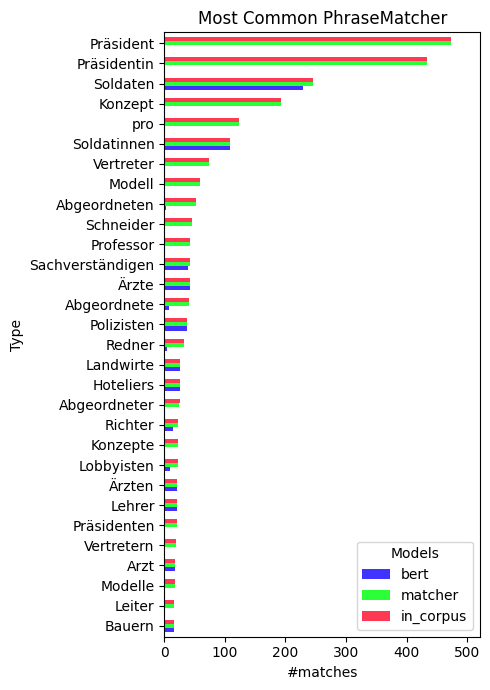

In [34]:
# Plot für Most Common PhraseMatcher
ax2 = most_common_matcher[['bert', 'matcher', 'in_corpus']].plot(kind='barh', width=bar_width, ylabel='Type',
                                                                 title='Most Common PhraseMatcher', color=[color_bert, color_matcher, color_in_corpus],
                                                                 figsize=figsize)
ax2.set(xlabel='#matches')
ax2.margins(x=0.1)
ax2.legend(title='Models', loc='lower right', bbox_to_anchor=(1, 0))
plt.tight_layout()
plt.savefig('most_common_matcher.png', bbox_inches='tight')
plt.show()

In [37]:
print_sentences('Redner', 10, None)

1375 741025


Die Hauptkritik , die ich für meine Fraktion und auch für meine Arbeitsgruppe äußern möchte , betrifft einen Punkt , der heute schon den einen oder anderen <font color='brown'> Redner </font> beschäftigt hat .

predicted BERT:		 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
predicted Matcher:	 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
O	-9.98386287689209	[CLS]	
O	-10.66395378112793	Die	
O	-9.769132614135742	Haupt	
O	-8.70833969116211	##kritik	
O	-10.71231460571289	,	
O	-10.48592472076416	die	
O	-9.870189666748047	ich	
O	-9.669095993041992	für	
O	-9.19890022277832	meine	
O	-5.88210916519165	Fraktion	
O	-10.178406715393066	und	
O	-10.332521438598633	auch	
O	-9.571854591369629	für	
O	-9.229562759399414	meine	
O	-6.11811637878418	Arbeitsgruppe	
O	-10.543571472167969	äußern	
O	-10.777807235717773	möchte	
O	-10.864420890808105	,	
O	-10.667943000793457	betrifft	
O	-10.085714340209961	einen	
O	-9.05313491821289	Punkt	
O	-10.16158676147461	,	
O	-10.100346565246582	der	
O	-10.112288475036621	heute	
O	-10.045658111572266	schon	
O	-8.420695304870605	den	
O	-8.226404190063477	einen	
O	-9.40388011932373	oder

Ich kann mich dem Lob anschließen , das hier einige <font color='brown'> Redner </font> schon zum Ausdruck gebracht haben .

predicted BERT:		 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
predicted Matcher:	 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
O	-9.665616989135742	[CLS]	
O	-9.983819007873535	Ich	
O	-10.460126876831055	kann	
O	-10.491665840148926	mich	
O	-10.160667419433594	dem	
O	-8.655763626098633	Lob	
O	-10.467660903930664	anschließen	
O	-10.956343650817871	,	
O	-10.123489379882812	das	
O	-10.28068733215332	hier	
O	-8.068153381347656	einige	
O	-1.5386714935302734	Red	
O	-0.3240165114402771	##ner	
O	-9.76190185546875	schon	
O	-10.0963134765625	zum	
O	-10.241203308105469	Ausdruck	
O	-10.478026390075684	gebracht	
O	-9.777143478393555	haben	
O	-10.289674758911133	.	
O	-8.144135475158691	[SEP]	
###


674 732033


Wenn man die <font color='green'> Rednerinnen </font> und <font color='green'> Redner </font> der Opposition hört , dann hat man den Eindruck , sie seien heilfroh , dass sie nicht in der Verantwortung stehen .

predicted BERT:		 [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
predicted Matcher:	 [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
O	-8.462418556213379	[CLS]	
O	-10.093812942504883	Wenn	
O	-9.714523315429688	man	
O	-7.080796241760254	die	
O	-0.2824784517288208	Red	
B-PROF	1.7962862253189087	##ner	
B-PROF	1.770897626876831	##innen	
O	-6.09326171875	und	
O	-0.559844970703125	Red	
B-PROF	1.3379504680633545	##ner	
O	-6.7649383544921875	der	
O	-3.7469804286956787	Opposition	
O	-9.437663078308105	hört	
O	-10.55436897277832	,	
O	-10.218099594116211	dann	
O	-10.07657241821289	hat	
O	-9.805192947387695	man	
O	-9.630664825439453	den	
O	-9.902006149291992	Eindruck	
O	-10.02676773071289	,	
O	-6.584395885467529	sie	
O	-8.548617362976074	seien	
O	-8.123650550842285	heil	
O	-8.27751350402832	##fr	
O	-7.842353343963623	##o	
O	-7.765928745269775	##h	
O	-9.756366729736328	,	
O	-9.886844635009766	dass	
O	-7.512509346008301	sie	


Alle <font color='green'> Redner </font> und <font color='orange'> Rednerinnen </font> hier und heute haben versichert :

predicted BERT:		 [0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
predicted Matcher:	 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
O	-8.08206844329834	[CLS]	
O	-7.774007797241211	Alle	
B-PROF	0.18998754024505615	Red	
B-PROF	2.097695827484131	##ner	
O	-6.135158061981201	und	
O	-0.08373129367828369	Red	
B-PROF	1.5558887720108032	##ner	
B-PROF	1.7555556297302246	##innen	
O	-7.148386478424072	hier	
O	-9.43942928314209	und	
O	-8.59262466430664	heute	
O	-8.283506393432617	haben	
O	-8.47193431854248	versichert	
O	-9.300390243530273	:	
O	-7.053218364715576	[SEP]	
###


506 746904


Darauf ist im Übrigen kein <font color='brown'> Redner </font> der Koalitionsfraktionen eingegangen .

predicted BERT:		 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
predicted Matcher:	 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
O	-8.244464874267578	[CLS]	
O	-9.583389282226562	Darauf	
O	-8.71200180053711	ist	
O	-9.962583541870117	im	
O	-9.415898323059082	Übrigen	
O	-7.802816867828369	kein	
O	-2.094792604446411	Red	
O	-0.7570240497589111	##ner	
O	-7.334971904754639	der	
O	-5.756607532501221	Koalitions	
O	-5.66070556640625	##fraktion	
O	-6.248568058013916	##en	
O	-9.001760482788086	eingegangen	
O	-8.955402374267578	.	
O	-7.403435707092285	[SEP]	
###


1110 741571


Ich   finde es bemerkenswert , dass wir die Diskussion offenbar so reflexhaft miteinander führen können , dass man , Frau Höll , bereits im Vorhinein auf einen nachfolgenden <font color='brown'> Redner </font> eingehen kann ;

predicted BERT:		 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
predicted Matcher:	 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
O	-9.93254566192627	[CLS]	
O	-10.456363677978516	Ich	
O	-10.639272689819336	finde	
O	-10.806123733520508	es	
O	-10.402278900146484	bemerken	
O	-10.47932243347168	##swert	
O	-11.217819213867188	,	
O	-11.136207580566406	dass	
O	-10.787796020507812	wir	
O	-10.787863731384277	die	
O	-8.569506645202637	Diskussion	
O	-11.13667106628418	offenbar	
O	-10.935600280761719	so	
O	-10.776079177856445	re	
O	-10.732555389404297	##flex	
O	-11.117630958557129	##haft	
O	-11.23196029663086	miteinander	
O	-10.985408782958984	führen	
O	-11.124214172363281	können	
O	-11.198259353637695	,	
O	-11.070001602172852	dass	
O	-9.924260139465332	man	
O	-7.560753345489502	,	
O	-5.268913745880127	Frau	
O	-4.909685134887695	Hö	
O	-4.8907470703125	##ll	
O	-6.792690753936768	,	
O	-10.1346

Was mich bei SPD und Linken besonders enttäuscht hat : Keiner der beiden <font color='brown'> Redner </font> , weder Frau Tackmann noch Herr Schwanitz , ist auf die Ursachen eingegangen .

predicted BERT:		 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
predicted Matcher:	 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
O	-8.976171493530273	[CLS]	
O	-10.501806259155273	Was	
O	-8.992650032043457	mich	
O	-8.646650314331055	bei	
O	-5.389093399047852	SPD	
O	-8.44337272644043	und	
O	-4.888413429260254	Linken	
O	-10.378641128540039	besonders	
O	-9.819694519042969	enttäuscht	
O	-10.280128479003906	hat	
O	-9.937498092651367	:	
O	-7.94964599609375	Keine	
O	-6.595293045043945	##r	
O	-6.04993200302124	der	
O	-5.473638534545898	beiden	
O	-2.058429718017578	Red	
O	-0.3781293034553528	##ner	
O	-8.083949089050293	,	
O	-8.299395561218262	weder	
O	-5.664774417877197	Frau	
O	-6.00078010559082	Ta	
O	-5.8701558113098145	##ck	
O	-5.378739356994629	##mann	
O	-8.48108196258545	noch	
O	-7.454483985900879	Herr	
O	-5.501149654388428	Schwa	
O	-5.878812789916992	##nitz	
O	-8.468090057373047	,	
O	-8.890144348144531	ist	
O	-9.

Ich bin mittlerweile zu der Überzeugung gekommen , dass Sie eine fraktionsinterne Wette laufen haben , bei der es darum geht , dass jeder <font color='brown'> Redner </font> von Ihnen - ganz egal , zu welchem Thema Sie sprechen - einige Vokabeln verwenden muss .

predicted BERT:		 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
predicted Matcher:	 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
O	-9.859187126159668	[CLS]	
O	-10.30146312713623	Ich	
O	-10.461206436157227	bin	
O	-10.694918632507324	mittlerweile	
O	-10.475214958190918	zu	
O	-10.198266983032227	der	
O	-10.219087600708008	Überzeugung	
O	-10.57125473022461	gekommen	
O	-11.20716667175293	,	
O	-10.989160537719727	dass	
O	-10.408829689025879	Sie	
O	-10.512924194335938	eine	
O	-4.96295166015625	fra	
O	-6.177165508270264	##ktions	
O	-9.978631019592285	##intern	
O	-10.049708366394043	##e	
O	-9.203279495239258	Wett	
O	-9.67994499206543	##e	
O	-10.45903205871582	laufen	
O	-10.577153205871582	haben	
O	-11.136702537536621	,	
O	-10.737346649169922	bei	
O	-10.842734336853027	der	
O	-10.980756759643555	es	
O	-10.7408447265625	darum	
O	-10.969

Auch der Entwicklungsminister hat dies gefordert - einige <font color='brown'> Redner </font> haben es schon gesagt - , ebenso , wie ich glaube , die meisten Kollegen aus dem Entwicklungsausschuss .

predicted BERT:		 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
predicted Matcher:	 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
O	-9.231311798095703	[CLS]	
O	-9.726470947265625	Auch	
O	-8.13206958770752	der	
O	-2.4957163333892822	Entwicklungs	
O	-2.195159673690796	##minister	
O	-10.163655281066895	hat	
O	-10.601567268371582	dies	
O	-10.923385620117188	gefordert	
O	-9.79114055633545	-	
O	-8.52160930633545	einige	
O	-1.440258264541626	Red	
O	-0.5412484407424927	##ner	
O	-9.29814338684082	haben	
O	-10.499722480773926	es	
O	-10.450579643249512	schon	
O	-10.925875663757324	gesagt	
O	-9.777883529663086	-	
O	-7.90409517288208	,	
O	-9.645139694213867	ebenso	
O	-8.58993148803711	,	
O	-9.86144733428955	wie	
O	-8.689581871032715	ich	
O	-9.594200134277344	glaube	
O	-9.38879680633545	,	
O	-8.906970977783203	die	
O	-8.414693832397461	meisten	
O	-3.3131723403930664	Kollegen	
O	-6.126503944396973	aus	
O	-7.583697319030762	

Als letzter <font color='brown'> Redner </font> zu dem Haushalt für Arbeit und Soziales möchte ich zusammenfassend sagen , dass die Bundesregierung mit diesem Haushalt ihrer sozialen Verantwortung besonders gerecht wird .

predicted BERT:		 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
predicted Matcher:	 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
O	-9.398448944091797	[CLS]	
O	-8.880291938781738	Als	
O	-8.131084442138672	letzter	
O	-5.364444732666016	Red	
O	-3.2805211544036865	##ner	
O	-10.256306648254395	zu	
O	-9.929204940795898	dem	
O	-7.793244361877441	Haushalt	
O	-8.768001556396484	für	
O	-7.994882583618164	Arbeit	
O	-9.860031127929688	und	
O	-8.104743957519531	Sozial	
O	-8.713905334472656	##es	
O	-10.600099563598633	möchte	
O	-9.988564491271973	ich	
O	-10.871695518493652	zusammen	
O	-10.68544864654541	##fassen	
O	-10.758058547973633	##d	
O	-10.89089584350586	sagen	
O	-11.207380294799805	,	
O	-11.017610549926758	dass	
O	-9.763211250305176	die	
O	-5.882334232330322	Bundesregierung	
O	-10.394706726074219	mit	
O	-10.223899841308594	diesem	
O	-8.310022354125977	Haushalt	
O	-10.274914741516113	ihrer	
O	-9.666112899780273	sozi

In [33]:
comp_df = comp_df.sort_values('div')
melt_df = pd.melt(comp_df[['occupation', 'in_corpus', 'bert', 'matcher']], id_vars=['occupation'], var_name=['model'], value_name='count')

fig = px.bar(melt_df, x="occupation", color="model",
             y='count',
             title="A Grouped Bar Chart With Plotly Express in Python",
             barmode='group',
             height=600,
             log_y=True
            )

fig.write_html("/content/drive/MyDrive/PromotionDaten/TriDokSe5/speeches_2010_sample2_result.html")

KeyError: "['occupation'] not in index"